# Intro to Convolutions

In [1]:
# import modules
%matplotlib inline # displays plots in notebook

import math,sys,os,numpy as np
# math allows using mathematical equations
# sys allows communication with the system path & interpreter
# os allows operating system dependent functionality
# numpy allows working with arrays

from numpy.linalg import norm
# this returns one of 8 different matrix norms

from PIL import Image
# Python Imaging Library - this allows us to open and manipulate images

from matplotlib import pyplot as plt, rcParams, rc
# This is for plotting

from scipy.ndimage import imread
# read an image from file as an array

from skimage.measure import block_reduce
# Down-sample image by applying function to local blocks. Used in Pooling

import cPickle as pickle
# pickle is used for quickly and saving lists, objects, etc.

from scipy.ndimage.filters import correlate, convolve
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 6
%precision 4
np.set_printoptions(precision=4, linewidth=100)

In [2]:
# download the MNIST data from Tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
images, labels = mnist.train.images, mnist.train.labels
images = images.reshape((55000,28,28))
np.savez_compressed("MNIST_data/train", images=images, labels=labels)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# function called plots that takes in an array of images
def plots(ims, interp=False, titles=None):
    # images = array of images
    ims=np.array(ims)
    # mn = min value mx = max value
    mn,mx=ims.min(),ims.max()
    # f = a plot of the image pixel values
    f = plt.figure(figsize=(12,24))
    # for each value in images
    for i in range(len(ims)):
        # add a subplot
        sp=f.add_subplot(1, len(ims), i+1)
        # if the image has a title, set the image title
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

In [4]:
# load the MNIST data
data = np.load("MNIST_data/train.npz")
# images = the image column values
images=data['images']
# labels = label column values
labels=data['labels']
n=len(images)
images.shape

(55000, 28, 28)

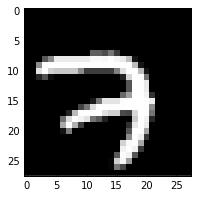

In [4]:
# so we have 55K 28px X 28px images
plot(images[0])

In [5]:
labels[0]

7

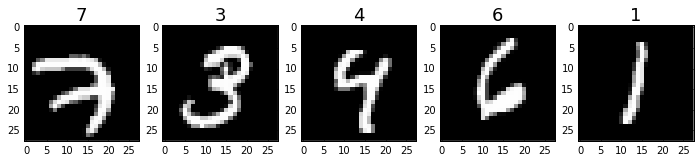

In [6]:
# Let's plot the first 5 images with their known labels
plots(images[:5], titles=labels[:5])

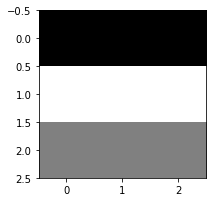

In [22]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

-1, 1, and 0 above are on an arbitrary scale. The smallest value will be seen as black and the largest value will be displayed as white, and numbers in between those two will be shades of grey.

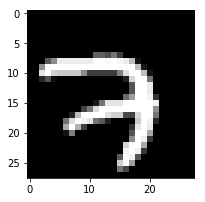

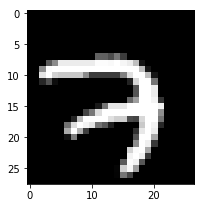

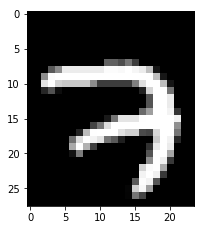

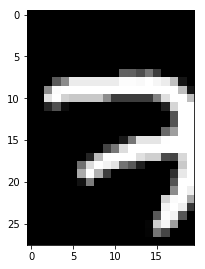

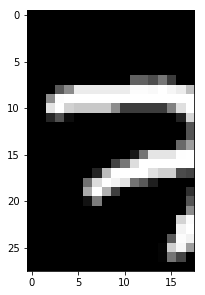

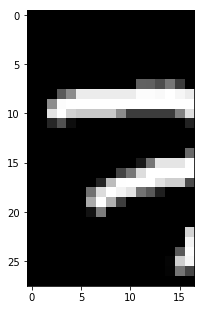

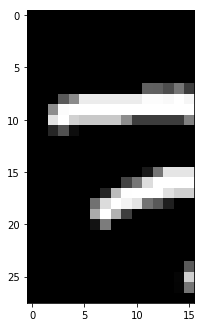

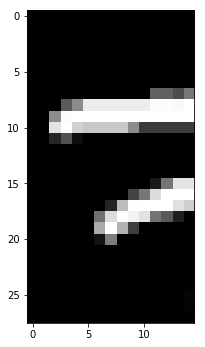

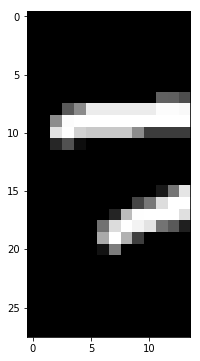

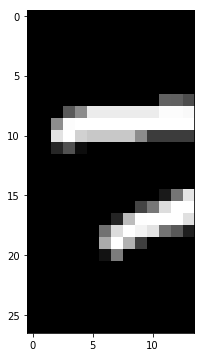

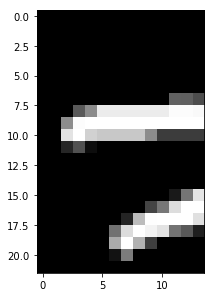

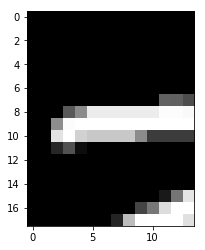

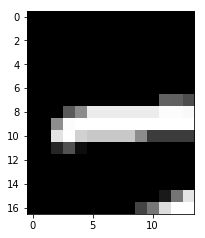

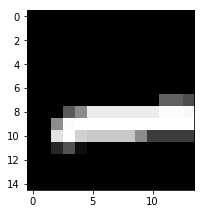

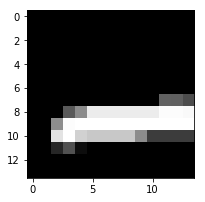

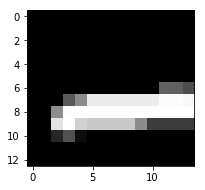

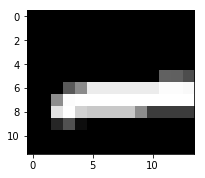

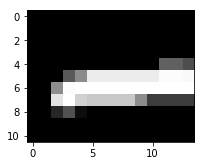

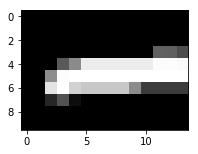

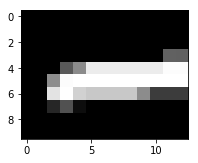

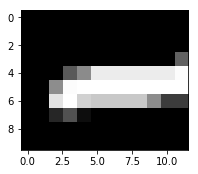

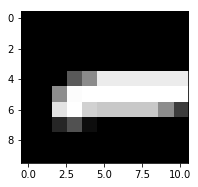

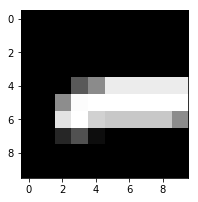

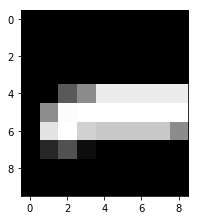

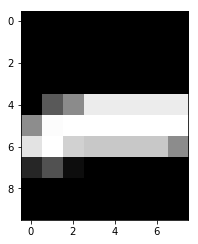

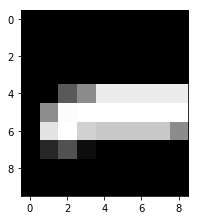

In [26]:
r=(0,28)
def zoomim(x1=0,x2=28,y1=0,y2=28):
    plot(images[0,y1:y2,x1:x2])
w=interactive(zoomim, x1=r,x2=r,y1=r,y2=r)
w

We'll start with our image of the hand-drawn 7, and zoom in a bit just so we can see the top portion of the character. We set **x1** = 1, **x2** = 10, **y1** = 4, and **y2** = 14. This results in an image that is 10 pixels wide by 9 pixels tall (include the 0's). The color white can be found ranging from coordinates: (2,6) through (8,6), (4,5) through (9,5), and (5,4) through (9,4).

In [29]:
# k is equal to the number of arguments given to w, which pulls its arguments from the sliders
k=w.kwargs
# we then set our dimensions selected in an array that stores the value of each pixel
# we use index_exp so the organization of the arrays matches the image
# this should result in an output of 10 rows with 9 values each
dims = np.index_exp[k['y1']:k['y2']:1,k['x1']:k['x2']]
images[0][dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.3529,  0.5412,  0.9216,  0.9216,  0.9216,  0.9216,  0.9216],
       [ 0.    ,  0.549 ,  0.9843,  0.9961,  0.9961,  0.9961,  0.9961,  0.9961,  0.9961],
       [ 0.    ,  0.8863,  0.9961,  0.8157,  0.7804,  0.7804,  0.7804,  0.7804,  0.5451],
       [ 0.    ,  0.149 ,  0.3216,  0.051 ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]], dtype=float32)

All of the 0's correspond to black pixels and the larger the number, the lighter its color. Now let's take `dims` from above and test for a correlation between `top` which is a filter to detect edges defined above. We scan through all 3x3 groups of pixels in `dims` and matrix-multiply them to the 3x3 `top` matrix. Any 3x3 pixel group from `dims` where the top 3 pixels are 0 and the middle row of pixels is 1 will show a high correlation to `top`.

Let's see what the correlation value is between this 9x9 array of pixel values<br>
![corr](corr_pixels.png)

Compared to this <br>
![top](top_pixels.png)

The result should be:<br> (0 x -1) + (0 x -1) + (0 x -1) + (.9216 x 1) + (.9216 x 1) + (.9216 x 1) + (.9961 x 0) + (.9961 x 0) + (.9961 x 0) = **2.7647**

In [30]:
corrtop = correlate(images[0], top)

In [31]:
corrtop[dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.3529,  0.8941,  1.8157,  2.3843,  2.7647,  2.7647,  2.7647,  2.7647],
       [ 0.549 ,  1.1804,  1.6353,  1.1608,  0.6039,  0.2235,  0.2235,  0.2235,  0.2235],
       [ 0.3373,  0.349 ,  0.1686, -0.3843, -0.6118, -0.6471, -0.6471, -0.8824, -1.4235],
       [-0.7373, -1.4118, -2.1765, -2.2196, -2.3255, -2.3412, -2.3412, -2.1059, -1.5647],
       [-0.149 , -0.4706, -0.5216, -0.3725, -0.051 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]], dtype=float32)

And you can see, we do have some instances where the correlation value is **2.7647**. The highest values signify where the pixels from our image match those of our predefined edge filter.

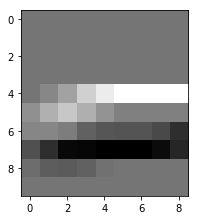

In [32]:
# Now we will plot the values from corrtop
plot(corrtop[dims])

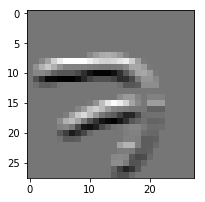

In [33]:
plot(corrtop)

In [34]:
# by rotating 90deg, we can create a left edge filter
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

True

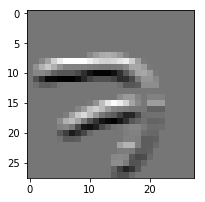

In [35]:
convtop = convolve(images[0], np.rot90(top,2))
plot(convtop)
np.allclose(convtop, corrtop)

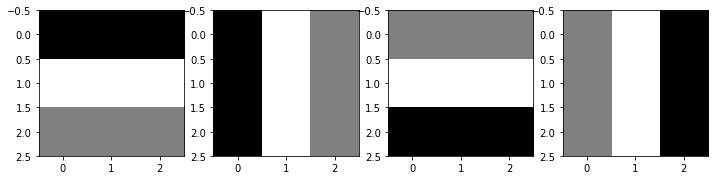

In [36]:
# here we are creating filters for top, left, bottom, and right
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

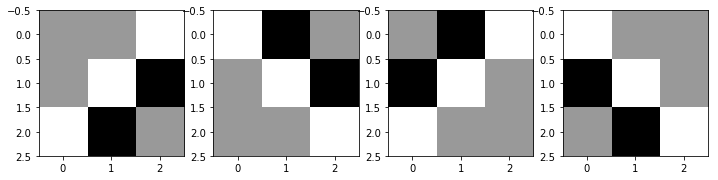

In [37]:
# and here we create diagonal filters
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

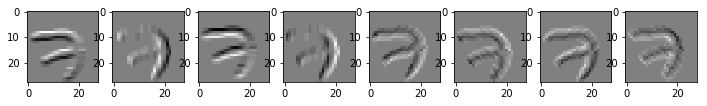

In [38]:
# here we will plot the correlation images for each of the 8 filters
# Top, Left, Bottom, Right, Bottom Right, Top Right, Top Left, Bottom Left
rots = straights + diags
corrs = [correlate(images[0], rot) for rot in rots]
plots(corrs)

## Pooling

Pooling condenses the feature map (generated by the convolution) into a pooled feature map. It does this by cycling through the feature map with a 7x7 square and stores the max number of features found in each cycle. The main reason we do this is to reduce the number of nodes in the Flattening step.

The objective is to down-sample an input image (or hidden layer output, etc.), and reduce its dimensionality to better allow for assumptions to be made about features contained in each of the sub-regions.

This also helps prevent over-fitting by producing an abstracted form of the input. In addition, it decreases the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.

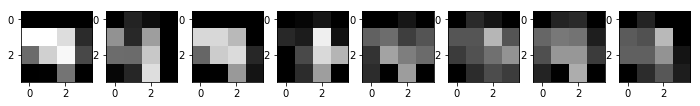

In [39]:
# create a function called pool that takes in an image
def pool(im): 
    # and calls the block_reduce function that passes a 7x7 grid through the 28x28 image
    # and returns the max value found in that 7x7 square
    return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

In [40]:
eights=[images[i] for i in xrange(n) if labels[i]==8]
ones=[images[i] for i in xrange(n) if labels[i]==1]

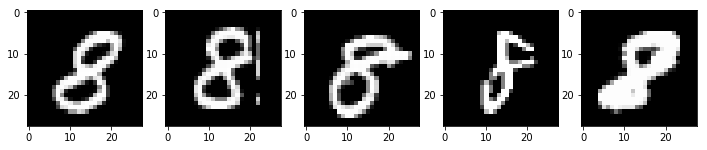

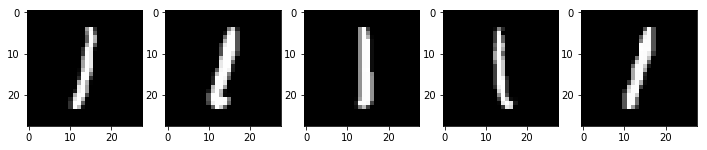

In [41]:
plots(eights[:5])
plots(ones[:5])

In [42]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights]) for rot in rots]

In [43]:
len(pool8), pool8[0].shape

(8, (5389, 4, 4))

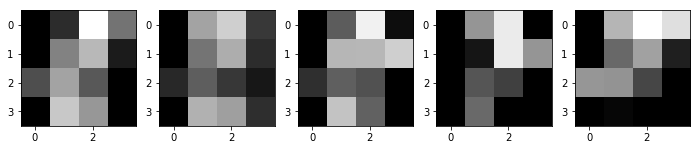

In [44]:
plots(pool8[0][0:5])

In [45]:
def normalize(arr): 
    return (arr-arr.mean())/arr.std()

In [46]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

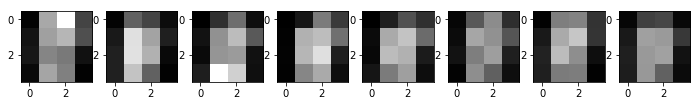

In [47]:
plots(filts8)

In [48]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

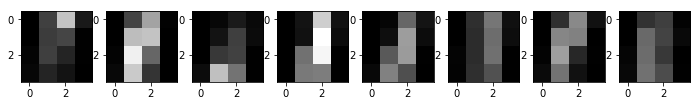

In [49]:
plots(filts1)

In [50]:
def pool_corr(im): 
    return np.array([pool(correlate(im, rot)) for rot in rots])

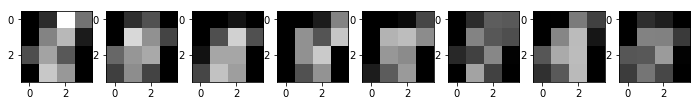

In [51]:
plots(pool_corr(eights[0]))

In [52]:
def sse(a,b): 
    return ((a-b)**2).sum()
def is8_n2(im): 
    return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

In [53]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(126.77776, 181.26105)

In [54]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights,ones]]

[5223, 287]

In [55]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights,ones]]

[166, 5892]

In [56]:
def n1(a,b): 
    return (np.fabs(a-b)).sum()

def is8_n1(im): 
    if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8):
        return 1
    else:
        return 0

In [57]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights,ones]]

[5129, 254]

In [58]:
[np.array([(1-is8_n1(im)) for im in ims]).sum() for ims in [eights,ones]]

[260, 5925]